# King County Real Estate Project
 **Authors:** CeCe Lacey, Warren Umbach, Kyle Vosen

# Overview and Business Problem
We set out to investigate the King County, Washington real estate market in 2015 in order to create a model for our clients. We sought to create a model that would best predict price of a home so that our clients could use it to help price homes they are buying or selling. We used linear regression to create a model using 15 features of 21,000 homes. these features were both discrete(categorical) and continous as well as internal home features as well as features of the surrounding neighborhood. Our final model is accurately predicting home prices with an average error of 148,000 dollars. We are confident in the success of our model.

# Modeling Process

This notebook goes through our entire process for data cleaning, finding features, modeling, and evaluation.

## Exploratory Data Analysis

## Data Cleaning 

### Housing Data

In the first step, we investigated our data columns so that we were aware of what we had. This process was done in another notebook called [firstmodel](./firstmodel.ipynb). In this notebook, we looked for missing values in each column. The basement_sqft column had an object data type and on further inspection, there was one question mark in it. That value was changed to a null and then the whole column was made a float. Then, the null value was replaced with the mean of the whole column. 

Next, we looked at a histogram of the price and saw that it was very skewed. We decided to drop 20 of the highest priced homes which was about 0.1% of the data.

The null values in the next columns, yr_renovated, waterfront, and view, were replaced with zeros so that they would effect the model. We decided to make a new column called reno that is a zero or one indicating whether the house has been renovated or not.

After that, we made three new columns called day, month, and year from the date column and then dropped the date column. We also had to make those columns into floats. Additionally, we used the month column to make another categorical feature called season.

### Median Income by Zipcode

We wanted to include some outside data to enhance our model so we went to IPUMS' (Integrated Public Use Microdata Series) National Historic Geographic Information System where we were able to retrieve data showing U.S. median income by zip code in 2015. Knowing that home prices are influenced by income levels we thought this wouuld be a helpful feature to add.

In [this notebook](./NEEDTOMOVECECEFILE.ipynb) We culled this data down to just the 93 King County zip codes in our data. We turned this data into a dictionary to map it onto our cleaned dataframe and create a new column median_by_zip.

### Nearest Whole Foods

The other outside data we choose to incorporate was proximity to Whole Foods. Whole Foods are notoriously expensive grocery stores to shop at so we can only assume that people living in homes located near them can afford said expensive groceries and likely live in a more expensive home. 

We gathered a dataset from Kaggle that had the latitude and longitude for all the Whole Foods in the United States in 2017. We found the Whole Foods that were just in our King County and used haversine to find the distance from each of our houses to each of the Whole Foods.

Then we created a column in our cleaned dataframe called closest_wf where we put the distance in miles of the closest Whole Foods from each house. 

## Data Understanding
In order to determine what features we wanted to use in our model we needed to dig in and investigate their relationships with each other as well as with price. We ultimately combined some features in a variety of different ways, added the two new features from outside data, and dropped features that were not supporting our model. 

## Feature Engineering
Next up was a little bit of feature engineering. In the notebook called [interactions](./interactions.ipynb), we looked at many combinations of features in order to tranform our data by multiplying or dividing feaures. We found a few features that were correlated and when combined had a big effect on our model such as multiplying sqft_living times grade and squaring the number of bathrooms.

We added these to our cleaed_df so that the group could work from it as well as a few more engineered features after digging deeper into some interactions with the new Whole Foods and income data.


### Feature Selection
We looked at many interactions between variables that are shown in the interactions notebook. We picked the best ones and then dropped the individual features to prevent colinearity. We also made a barplot of the weights of each feature and took out the very lowest ones.

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Column Names and descriptions for Our Final Model
* **Price** -  Price is prediction target
* **bedrooms** -  Number of Bedrooms/House
* **bathrooms_sq** -  Number of bathrooms/House squared
* **sqft_lot** -  Square footage of the lot
* **waterfront** - 1 or 0 the house has a view to a waterfront or not
* **condition** - How good the condition is ( Overall )
* **sqrt_sqft_above** - Square root of square footage of house apart from basement
* **sqft_basement** - Square footage of the basement
* **reno** - 1 or 0 has the house been renovated
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors
* **int_WFlivgrd** - Interaction of distance to nearest Whole Foods, square footage of house, and grade
* **median_by_zip** - Median income of zip code where house is located
* **view** - House has been viewed

In [2]:
#Reading in all of the data that we found from external sources and joining them all together.
df = pd.read_csv('cleaned_df',index_col=0)
df_med = pd.read_csv('mediandf.csv',index_col=0)
df_wf = pd.read_csv('Closest_WF',index_col=0)

In [3]:
#Dropping the id column and then making all of the engineered features.
df.drop('id',axis=1,inplace=True)
df = df.join(df_med)
df = df.join(df_wf)
#waterfront time grade
df['sqrt_long_times_WF'] = np.sqrt(abs(df['long'] * df['Closest_WF']))
df['yr_built_times_grade'] = df['yr_built'] * df['grade']
df['water_times_grade'] = df['waterfront'] * df['grade']
df['sqrt_sqft_above'] = np.sqrt(abs(df['sqft_above']))
df['int_WFlivgrd'] = np.sqrt(abs(df['sqft_living_times_grade'])) * np.sqrt(abs(df['Closest_WF']))
# ('sqft_living_times_grade', 'Closest_WF', 0.798)

Dropping 200 (1%) more of the most expensive houses to get a more normal price distribution.

In [4]:
drop_rows = df['price'].sort_values(ascending=False)[:200]
df.drop(drop_rows.index,axis=0,inplace=True)

In [5]:
#import model packages and fit the basic model
#for testing
from sklearn.model_selection import cross_val_score
#adding some more model testing
from sklearn.model_selection import KFold
#train test split
from sklearn.model_selection import train_test_split
#scoring
#feature elimination
from sklearn.feature_selection import RFE
#scoring
from sklearn.metrics import mean_squared_error
#trying some polynomial features

### Column Names and descriptions for features used in our final model.
* **Price** -  Price is prediction target
* **bedrooms** -  Number of Bedrooms/House
* **bathrooms_sq** -  Number of bathrooms/House squared
* **sqft_lot** -  Square footage of the lot
* **waterfront** - 1 or 0 the house has a view to a waterfront or not
* **condition** - How good the condition is ( Overall )
* **sqrt_sqft_above** - Square root of square footage of house apart from basement
* **sqft_basement** - Square footage of the basement
* **reno** - 1 or 0 has the house been renovated
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the lots of the nearest 15 neighbors
* **int_WFlivgrd** - Interaction of distance to nearest Whole Foods, square footage of house, and grade
* **median_by_zip** - Median income of zip code where house is located
* **view** - House has been viewed

Setting which categorical and continuous features to use in the model.

In [6]:
#defining which values are categorical or not
#'bedrooms','floors','condition','zipcode','season','view'
categoricals = ['bedrooms','waterfront','view','condition','reno','median_by_zip']

continuous = ['price','sqft_lot','sqrt_sqft_above','sqft_basement','lat','long',
              'sqft_living15','sqft_lot15',
              'bathrooms_sq','int_WFlivgrd']

df_cont = df[continuous]

Now, one hot encode the categorical features and combine them with the continuous ones.

In [7]:
#one hot encode the categoricals
df_ohe = pd.get_dummies(df[categoricals])
#combine the data into one frame
preprocessed = pd.concat([df_cont, df_ohe],axis=1)
#make feature set by dropping price
X = preprocessed.drop('price',axis=1)

#make target set
y = preprocessed['price']


In [8]:
y

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21592    360000.0
21593    400000.0
21594    402101.0
21595    400000.0
21596    325000.0
Name: price, Length: 21377, dtype: float64

Comparing different scalers by making a function to take the output of scalers and return the score for multiple scalers.

This function applies scaling to the features depending on the user input.

In [9]:
#scale here
def scales(scaler,X):
    #suppress warnings
    import warnings
    from sklearn.exceptions import DataConversionWarning
    
    warnings.filterwarnings(action='ignore', category=RuntimeWarning)
                        
#     from sklearn.preprocessing import MinMaxScaler
#     from sklearn.preprocessing import minmax_scale
    '''choose which scaler to use. Pass the name and features to scale'''
    
    if scaler == 'standard':
        from sklearn.preprocessing import StandardScaler
        standard = StandardScaler().fit_transform(X)
        choice = standard

    elif scaler == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        minmax = MinMaxScaler().fit_transform(X)
        choice = minmax
    elif scaler == 'maxabs':
        from sklearn.preprocessing import MaxAbsScaler
        maxabs = MaxAbsScaler().fit_transform(X)
        choice = maxabs
    elif scaler == 'robust':
        from sklearn.preprocessing import RobustScaler
        robust = RobustScaler().fit_transform(X)
        choice = robust
    elif scaler == 'norm':
        from sklearn.preprocessing import Normalizer
        norm = Normalizer().fit_transform(X)
        choice = norm
    elif scaler == 'quant':
        from sklearn.preprocessing import QuantileTransformer
        quant = QuantileTransformer().fit_transform(X)
        choice = quant
    elif scaler == 'power':
        from sklearn.preprocessing import PowerTransformer
        power = PowerTransformer().fit_transform(X)
        choice = power
    elif scaler == 'none':
        choice = X
        
    choice = pd.DataFrame(choice)
    return choice

This is where the selected model is trained and where the train test split is made.

In [10]:

def model_train(scaled_X,y,n_feats,estimator):

    #make train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state=2)
    #use the best features
    #selector = RFE(estimator, n_features_to_select=n_feats, step=1)
    #selector = selector.fit(X_test, y_test)
    estimator = estimator.fit(X_test, y_test)
    return estimator, y_train, y_test, X_test, X_train

This function scores the model in a few different ways. It gets predictions for the train and test set and then uses those for root mean square error, r2 score, and cross validation. The r2 score is mostly ignored, but we optimized for the lowest error while keeping the train and test error difference minimal. I am using KFold for the cross validation with five splits and shuffling.

In [11]:
def model_score(estimator,y_train,y_test,X_test,X_train,n_splits=5):
    '''Takes estimator, y_train, y_test, X_test, X_train, n_splits
        n_splits is optional'''
    from sklearn.metrics import r2_score
    #get predicted values
    y_hat_train = estimator.predict(X_train)
    y_hat_test = estimator.predict(X_test)
    #r2 scoring
    split_score = r2_score(y_test, y_hat_test)
    r2_score = split_score.mean()
    #RMSE scoring
    RMSE_test = mean_squared_error(y_test,y_hat_test,squared=False)
    RMSE_train = mean_squared_error(y_train,y_hat_train,squared=False)
    RMSE_diff = abs(RMSE_test - RMSE_train)
    # RMSE_test,RMSE_train
    #cross val scoring using KFold splits
    cv = KFold(n_splits=n_splits,shuffle=True)
    cv_score = cross_val_score(estimator,X_test,y_test,scoring='r2',cv=cv)
    cv_scores = cv_score.mean()
    #estimator coefs to plot
    coefs = estimator.coef_ 
    return round(r2_score,3),round(RMSE_diff,3),round(cv_scores,3),round(RMSE_test,3),round(RMSE_train,3),coefs

This function calculates the model error for 10 bins sizes and then plots them.

In [12]:
def plot_bin(est,X,y,bins=10):
    groups = pd.qcut(y,bins)
    frame = pd.DataFrame(groups)
    frame['error'] = est.predict(X) - y
    frame.columns = ['bins','error']
    frame = frame.groupby('bins').mean()
    fig, ax = plt.subplots(figsize=(15,5))

    #y = abs(coef_hist[1].values)

    y = frame['error'].values
    labels = frame.index
    sns.barplot(y=y,x=labels,ax=ax)
    plt.xticks(rotation=45);
    plt.title('Error by Bin');
    plt.ylabel('Error in Dollars')
    plt.xlabel('Price Bins in Dollars')
    
    return frame

This is the last function that chooses the model and prints out the scores. It also returns all variables so that they can be used for plotting.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
#set to degree 2, 3 is too slow
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
def get_scores(X=X):
    scalers = ['standard']
    estimators = ['linreg']
    for estimator in estimators:     
            if estimator == 'linreg':
                est = LinearRegression(n_jobs=4)
            elif estimator == 'sgd':
                est = SGDRegressor()
            elif estimator == 'ridge':
                est = Ridge(alpha=0.4,max_iter=1000)
            elif estimator == 'lasso':
                est = Lasso(alpha=0.1,max_iter=1000,tol=10000)
            elif estimator == 'kn':
                est = KNeighborsRegressor(n_neighbors=20,n_jobs=4)
            elif estimator == 'tree':
                est = tree.DecisionTreeRegressor()
            for scaler in scalers:
                scaled_X = scales(scaler,X)
                model_trains = model_train(scaled_X,y,10,est)
                estimator = model_trains[0]
                y_train = model_trains[1]
                y_test = model_trains[2]
                X_test = model_trains[3]
                X_train = model_trains[4]
                r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train, coefs = model_score(estimator,
                                       y_train,
                                       y_test,
                                       X_test,
                                       X_train,
                                       5)
                frame = plot_bin(estimator, X_test, y_test)
                print(f'Model used: {est}\n'
                      f'Scaler used: {scaler}\n'
                      f'Model scores are:\n' f'r2_score: {r2_score}\n' 
                      f'RMSE difference: {RMSE_diff}\n'
                      f'Test RMSE: {RMSE_test}\n'
                      f'Train RMSE: {RMSE_train}\n'  
                      f'Cross Val Scores: {cv_score}\n\n') 
    return estimator,scaler,r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train,coefs, frame

I call the score function and get the estimator coefficients.

Model used: LinearRegression(n_jobs=4)
Scaler used: standard
Model scores are:
r2_score: 0.721
RMSE difference: 1577.056
Test RMSE: 149120.457
Train RMSE: 147543.401
Cross Val Scores: 0.717




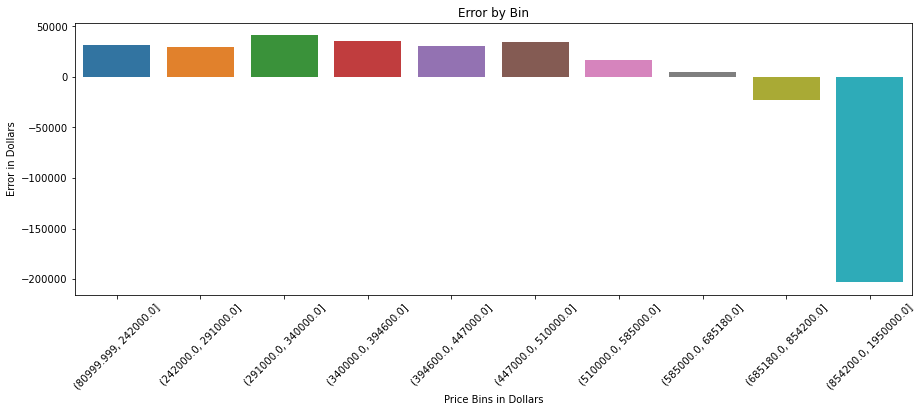

In [14]:
estimator,scaler,r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train,coefs, frame = get_scores(X)

coefficients = list(zip(X.columns,coefs))

Looking at the absolute error for each bin.

In [15]:
frame['error'] = round(abs(frame['error']))
frame

,error
bins,
"(80999.999, 242000.0]",31186.0
"(242000.0, 291000.0]",30142.0
"(291000.0, 340000.0]",41377.0
"(340000.0, 394600.0]",36003.0
"(394600.0, 447000.0]",30432.0
"(447000.0, 510000.0]",34337.0
"(510000.0, 585000.0]",16582.0
"(585000.0, 685180.0]",5359.0
"(685180.0, 854200.0]",22612.0


Plotting a few variables to get a sense of the relationships

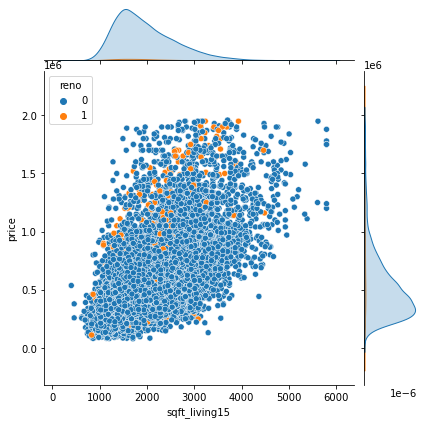

In [16]:
ax = sns.jointplot(x='sqft_living15', y="price", hue='reno',data=df);

Plotting the coefficients used in the model so we can see which are the have the strongest effect on our model.

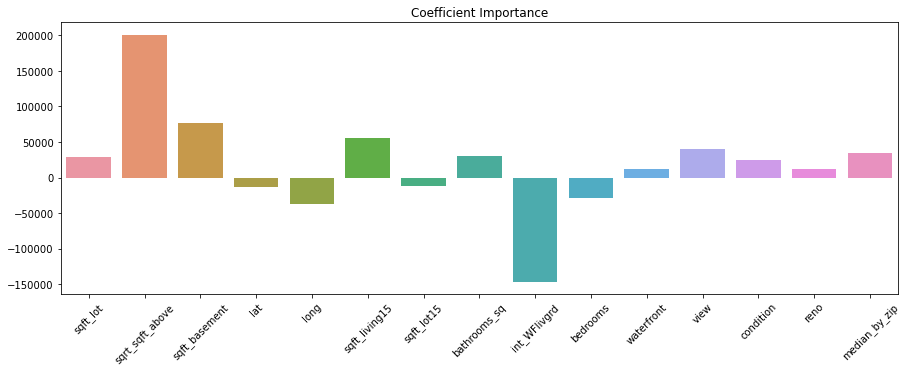

In [17]:
coef_hist = pd.DataFrame(coefficients)

fig, ax = plt.subplots(figsize=(15,5))

len(coef_hist[1].values),len(coef_hist[0].values)

#y = abs(coef_hist[1].values)

y = coef_hist[1].values
labels = coef_hist[0].values
ax = sns.barplot(y=y,x=labels)
plt.xticks(rotation=45);
plt.title('Coefficient Importance');

## Evaluation

The model is scored based on the root mean square error of the train and test sets,
a cross validation, and the error of the test set using 10 price bins from 81 thousand dollars to 2 million dollars.

* Train Test Split Scores: 
Test Root Mean Squared Error: 149120.457
Train Root Mean Squared Error: 147543.401

* Cross Validation Score: 0.717

* Quantile Test Score
Most error is between 854 thousand and 2 million. The error in all other bins is around 30 thousand dollars down to 5.5 thousand dollars for one bin.

Additionally, the coefficient importance was plotted to be sure that all features were contributing sufficiently to the model.

## Conclusion and Next Steps